In [1]:
%matplotlib inline
!pip install torchsummary

In [2]:
import albumentations as A
import torchvision
import torch
import torch.optim as optim
import torch.nn as nn

import numpy as np

from main import Cifar10Dataset
from utils import show_grid
import matplotlib.pyplot as plt

from torch.utils.tensorboard import SummaryWriter

# Writer will output to ./runs/ directory by default
writer = SummaryWriter()

2021-11-23 22:07:57.777305: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [3]:
params = dict(
    augmentation = [
    A.HorizontalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.Normalize()
    ],
    batch_size = 128,
    # optimizer = optim.SGD(),
    criterion = nn.CrossEntropyLoss(),
    epochs = 4,
    writer = writer,
    freq = 999,
    lr = [0.01, 0.001],
    shuffle = [True, False]
)

In [4]:
# transform = A.Compose([
#     #A.RandomCrop(width=256, height=256),
#     A.HorizontalFlip(p=0.5),
#     A.RandomBrightnessContrast(p=0.2),
# ])
transform = A.Compose(params['augmentation'])

trainset = Cifar10Dataset(root='./data', train=True, download=True, transform=transform)
testset = Cifar10Dataset(root='./data', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [5]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=params['batch_size'], shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=params['batch_size'], shuffle=False, num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


 bird    dog    car   bird  plane   frog   bird    dog  truck    dog  truck    cat  horse  plane    car    dog  truck   frog  plane  horse    dog   bird   bird  plane    car   deer   frog    dog    cat   frog    cat    cat    car   deer    dog  plane   bird    dog  horse    car   deer   deer  truck    dog   deer   frog    cat   deer    cat   bird   deer  plane   deer   frog   bird   ship    dog   deer    car    dog    cat    dog   bird   ship   deer    dog    dog   ship   ship   frog  truck    cat    car  horse   bird   ship   frog    car   deer  plane    cat  truck  truck    cat   ship    car   ship    cat   frog    car  plane    cat  truck    cat   bird  horse  truck  plane  plane   frog    cat   frog   bird    dog    cat  plane   ship   deer    car   frog  horse  truck   ship    cat    car  truck    car   deer   ship  horse   bird  truck  plane  horse   frog   frog   deer    dog


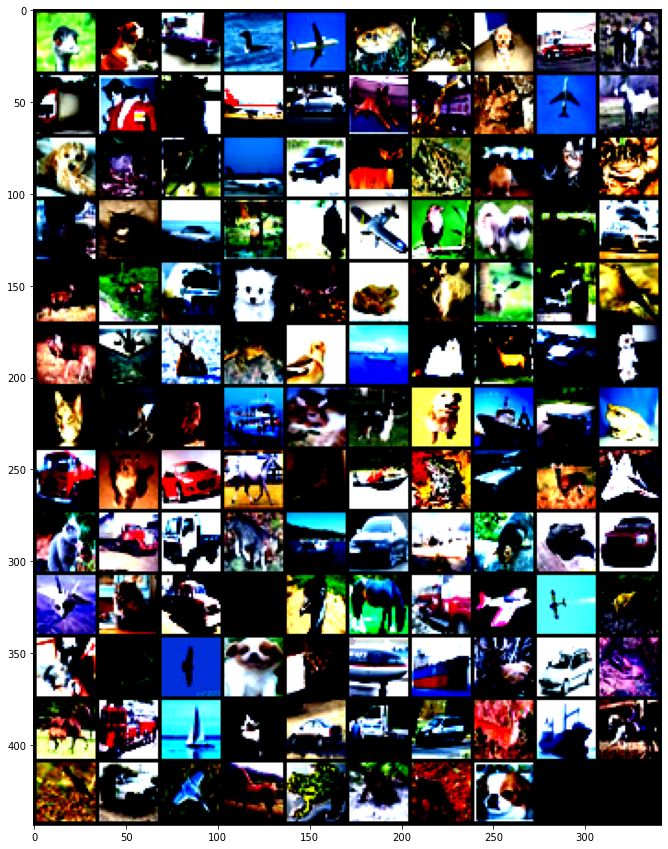

In [131]:
# get some random training images
params['classes'] = trainset.classes
dataiter = iter(trainloader)
images, labels = dataiter.next()
show_grid(images, labels)

## Model

from models.resnet import Net
from torchsummary import summary

net = Net().to(device)

print(device)
summary(net, input_size=(3, 32, 32))

In [7]:
from models.resnet import ResNet18
from torchsummary import summary

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

net = ResNet18().to(device)
print('device', device)
summary(net, input_size=(3, 32, 32))

device cuda:0
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14     

In [8]:
lr = 0.01
criterion = params['criterion'] #nn.CrossEntropyLoss()
params['optimizer'] = optim.SGD(net.parameters(), lr=lr,
                      momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(params['optimizer'], T_max=200)

In [9]:
def plot_loss_update(epoch, epochs, mb, train_loss, valid_loss):
    """ dynamically print the loss plot during the training/validation loop.
        expects epoch to start from 1.
    """
    x = range(1, epoch+1)
    y = np.concatenate((train_loss, valid_loss))
    graphs = [[x,train_loss], [x,valid_loss]]
    x_margin = 0.2
    y_margin = 0.05
    x_bounds = [1-x_margin, epochs+x_margin]
    y_bounds = [np.min(y)-y_margin, np.max(y)+y_margin]

    mb.update_graph(graphs, x_bounds, y_bounds)


Epoch: 1
Loss: 501.1632419228554
Accuracy for class plane is: 0.0 %
Accuracy for class car   is: 0.0 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 0.0 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 0.0 %
Accuracy for class frog  is: 0.0 %
Accuracy for class horse is: 0.0 %
Accuracy for class ship  is: 0.0 %
Accuracy for class truck is: 0.0 %
Saving..


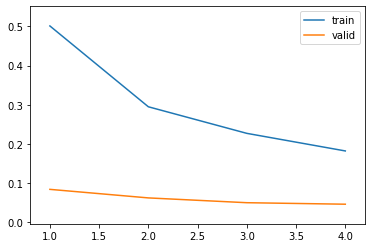


Epoch: 2
Loss: 294.89227509498596
Accuracy for class plane is: 0.0 %
Accuracy for class car   is: 0.0 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 0.0 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 0.0 %
Accuracy for class frog  is: 0.0 %
Accuracy for class horse is: 0.0 %
Accuracy for class ship  is: 0.0 %
Accuracy for class truck is: 0.0 %
Saving..

Epoch: 3
Loss: 227.07911613583565
Accuracy for class plane is: 0.0 %
Accuracy for class car   is: 0.0 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 0.0 %
Accuracy for class deer  is: 0.0 %
Accuracy for class dog   is: 0.0 %
Accuracy for class frog  is: 0.0 %
Accuracy for class horse is: 0.0 %
Accuracy for class ship  is: 0.0 %
Accuracy for class truck is: 0.0 %
Saving..

Epoch: 4
Loss: 182.18858164548874
Accuracy for class plane is: 0.0 %
Accuracy for class car   is: 0.0 %
Accuracy for class bird  is: 0.0 %
Accuracy for class cat   is: 0.0 %
Accuracy for class deer  is: 0.0 %
Ac

In [10]:
from main import train, test
from fastprogress.fastprogress import master_bar, progress_bar
from time import sleep

mb = master_bar(range(1, params['epochs']+1))
train_loss, valid_loss = [], []
for epoch in mb:
    params['epoch'], params['mb'] = epoch, mb
    train_loss.append(train(trainloader, net, params, train_loss))
    valid_loss.append(test(testloader, net, params, valid_loss))
    scheduler.step()
    mb.main_bar.comment = f'first bar stat'
    mb.write(f'Finished epoch {epoch}. Train Loss: {train_loss}, Test Loss {valid_loss}')
    plot_loss_update(epoch, params['epochs'], mb, train_loss, valid_loss)


https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82

## Gradcam

In [14]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

In [132]:
target_layers = [net.layer4[-1]]
input_tensor = np.transpose(images,(0,3,1,2))
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=net, target_layers=target_layers, use_cuda=True)

target_category = 7
# You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
grayscale_cam = cam(input_tensor=input_tensor, target_category=target_category)

In [133]:
array = np.transpose(input_tensor[0],(1,2,0)).numpy()
array2 = ((array-array.mean())/array.max())
visualization = show_cam_on_image(array2, grayscale_cam[0], use_rgb=True)

In [134]:
visualization.shape

(32, 32, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


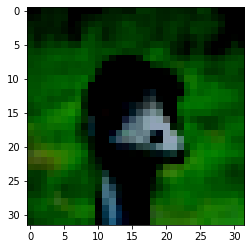

In [135]:
plt.imshow(array2)

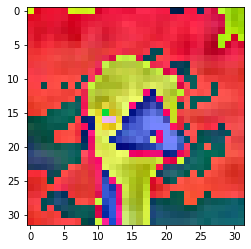

In [136]:
plt.imshow(visualization)